In [1]:
import os, sys

sys.path.append(os.path.abspath('../../pymssa'))
sys.path.append(os.path.abspath('../../'))

import warnings
warnings.filterwarnings("ignore")

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams['figure.facecolor'] = 'white'

# import Spectrum
from Libraries.Spectrum import MSSAUse

import statsmodels.api as sm
import statsmodels.tsa.api as smt

<AxesSubplot:xlabel='idate'>

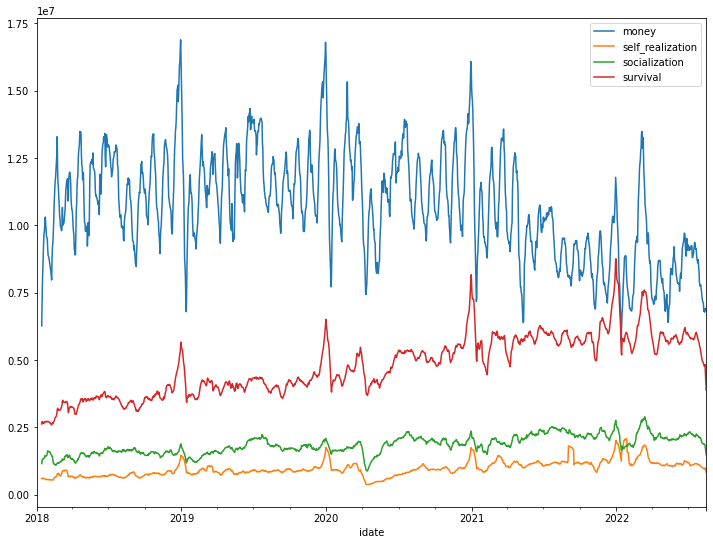

In [12]:
data=pd.read_csv('sssr.csv', parse_dates=['idate'])
data.set_index('idate', inplace=True)
data.rolling(14).mean().plot()

In [13]:
data.head(10)

,money,self_realization,socialization,survival
idate,,,,
2018-01-01,1122036.88,171228.65,321307.95,869086.74
2018-01-02,2359030.22,541010.38,740730.04,2458526.84
2018-01-03,2602570.80,645340.02,1354940.71,2683265.63
2018-01-04,3113277.69,651615.49,1284518.79,2656372.32
2018-01-05,3170849.62,607035.75,1235404.95,3001317.26
2018-01-06,3454564.37,710710.93,1080637.82,2727519.77
2018-01-07,2149320.16,532258.50,872707.64,2466056.93
2018-01-08,3073467.99,526878.59,932157.28,2318634.37
2018-01-09,8279503.24,495825.84,1399544.27,1894320.47


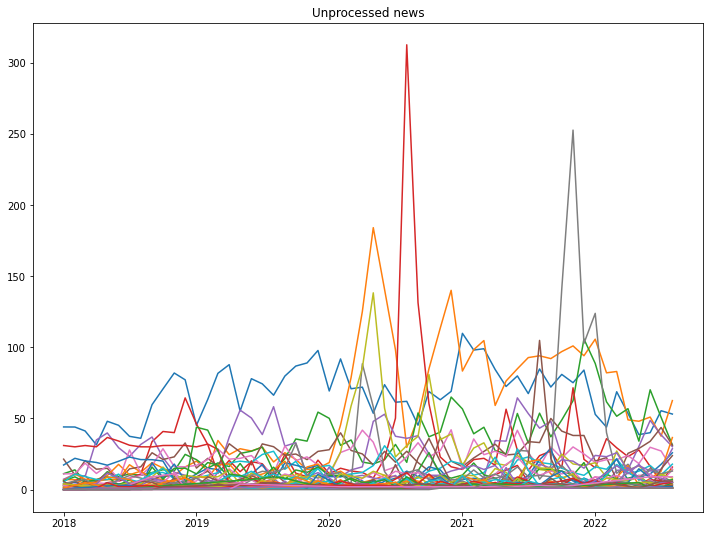

In [14]:
news_raw = pd.read_csv("../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv", parse_dates=["Unnamed: 0"])
news_raw = news_raw.rename(columns={"Unnamed: 0": "idate"})
news_raw = news_raw.set_index("idate")
news_raw = news_raw.iloc[:, 2:]

plt.plot(news_raw);
plt.title("Unprocessed news");

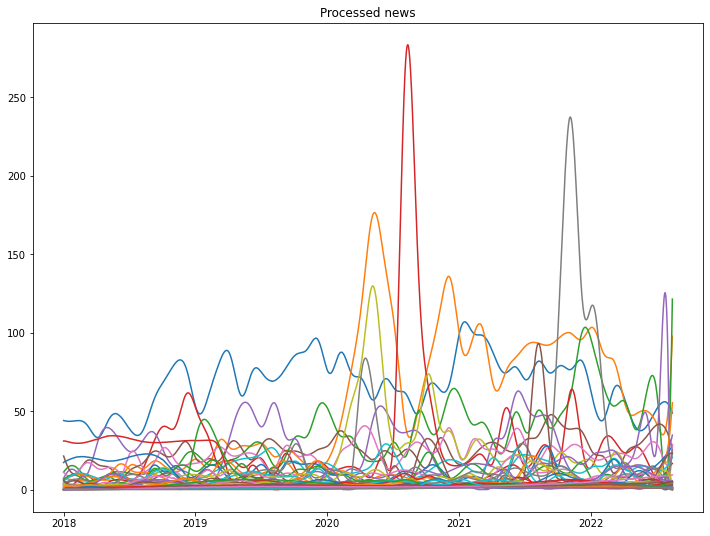

In [15]:
# Cubic spline interpolation for daily values
old_idx = news_raw.index
new_idx = pd.date_range(start=data.index.min(),
                        end=data.index.max(),
                        freq='D')
news = news_raw.reindex(new_idx).interpolate(method='spline', order=3)
news = news.ewm(span=20).mean()
news[news<0] = 0.0

plt.plot(news);
plt.title("Processed news");

Text(0, 0.5, 'Topic frequency')

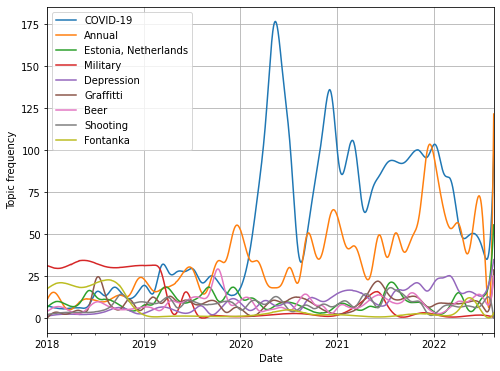

In [25]:
# desired_topics = 20
thr = 5

plt.rcParams['figure.figsize'] = [8, 6]

for col in news.columns:
    result = smt.stattools.adfuller(news[col])
    stat = (result[1] < 0.05) and (result[0] < result[4]['5%'])
    if stat or news[col].mean() < thr:
        news = news.drop(columns=[col])

news.plot()#;plt.plot(news, lw=2);

lg = ["COVID-19", "Annual", "Estonia, Netherlands", "Military", "Depression", "Graffitti",
      "Beer", "Shooting", "Fontanka"]

plt.legend(lg);
plt.grid();
plt.xlabel("Date")
plt.ylabel("Topic frequency")
# plt.legend(news.columns);
# plt.title(f"{len(news.columns)} topics left (more than {thr} on average and non-stationary)")

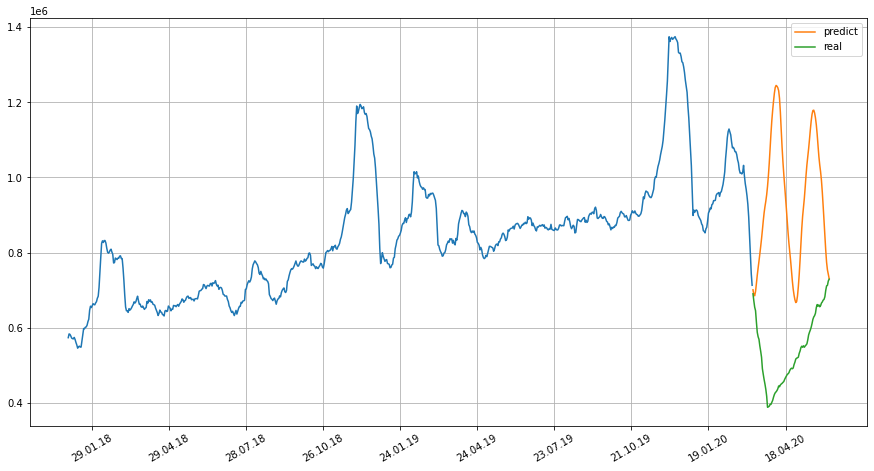

In [25]:
x0, fwd, smwin = 800, 90, 28

dat = data['self_realization'].rolling(smwin).mean().dropna().values
y = MSSAUse(dat[:x0], fwd, prds=[], predictors=None)
x = np.arange(x0, x0+fwd)
xt = np.arange(smwin, x0+fwd+smwin, 90)

plt.plot(dat[:x0])
plt.plot(x, y, label='predict')
plt.plot(x, dat[x0:x0+fwd], label='real')
plt.xticks(xt, data.index.strftime('%d.%m.%y')[xt], rotation=30)
plt.legend()
plt.grid()
plt.show()

MSSAUse(dat[:x0], fwd, <b>prds=[], predictors=None</b>)

<i>predictors</i> - DataFrame из Pandas с временными рядами
<i>prds</i> - список словарей о предикторах, то есть новостях. В нашем случай, наверное, один элемент. 
{prds: имя столббца из predictors, lag: временной сдвиг} 

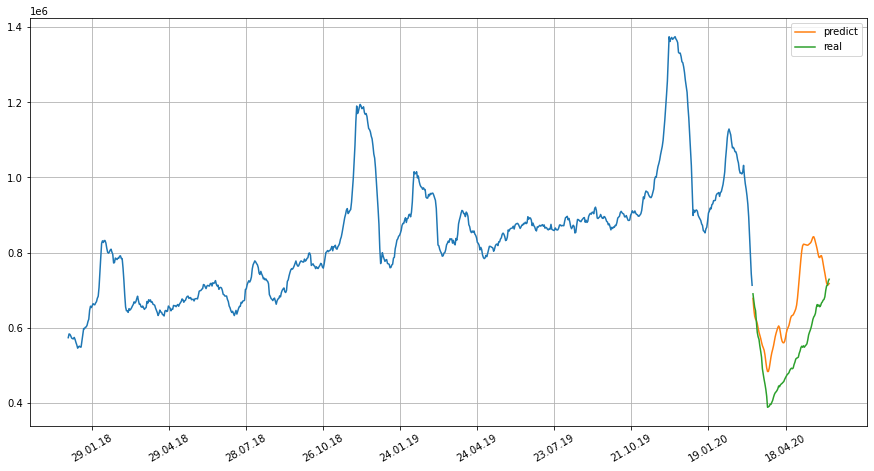

In [21]:
x0, fwd, smwin = 800, 90, 28

dat = data['self_realization'].rolling(smwin).mean().dropna().values

prds = []
for col in news.columns:
    prds.append({"prd": col, "lag": 0})

y = MSSAUse(dat[:x0], fwd, prds=prds, predictors=news.iloc[:x0])
x = np.arange(x0, x0+fwd)
xt = np.arange(smwin, x0+fwd+smwin, 90)

plt.plot(dat[:x0])
plt.plot(x, y, label='predict')
plt.plot(x, dat[x0:x0+fwd], label='real')
plt.xticks(xt, data.index.strftime('%d.%m.%y')[xt], rotation=30)
plt.legend()
plt.grid()

In [24]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    
    Returns
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

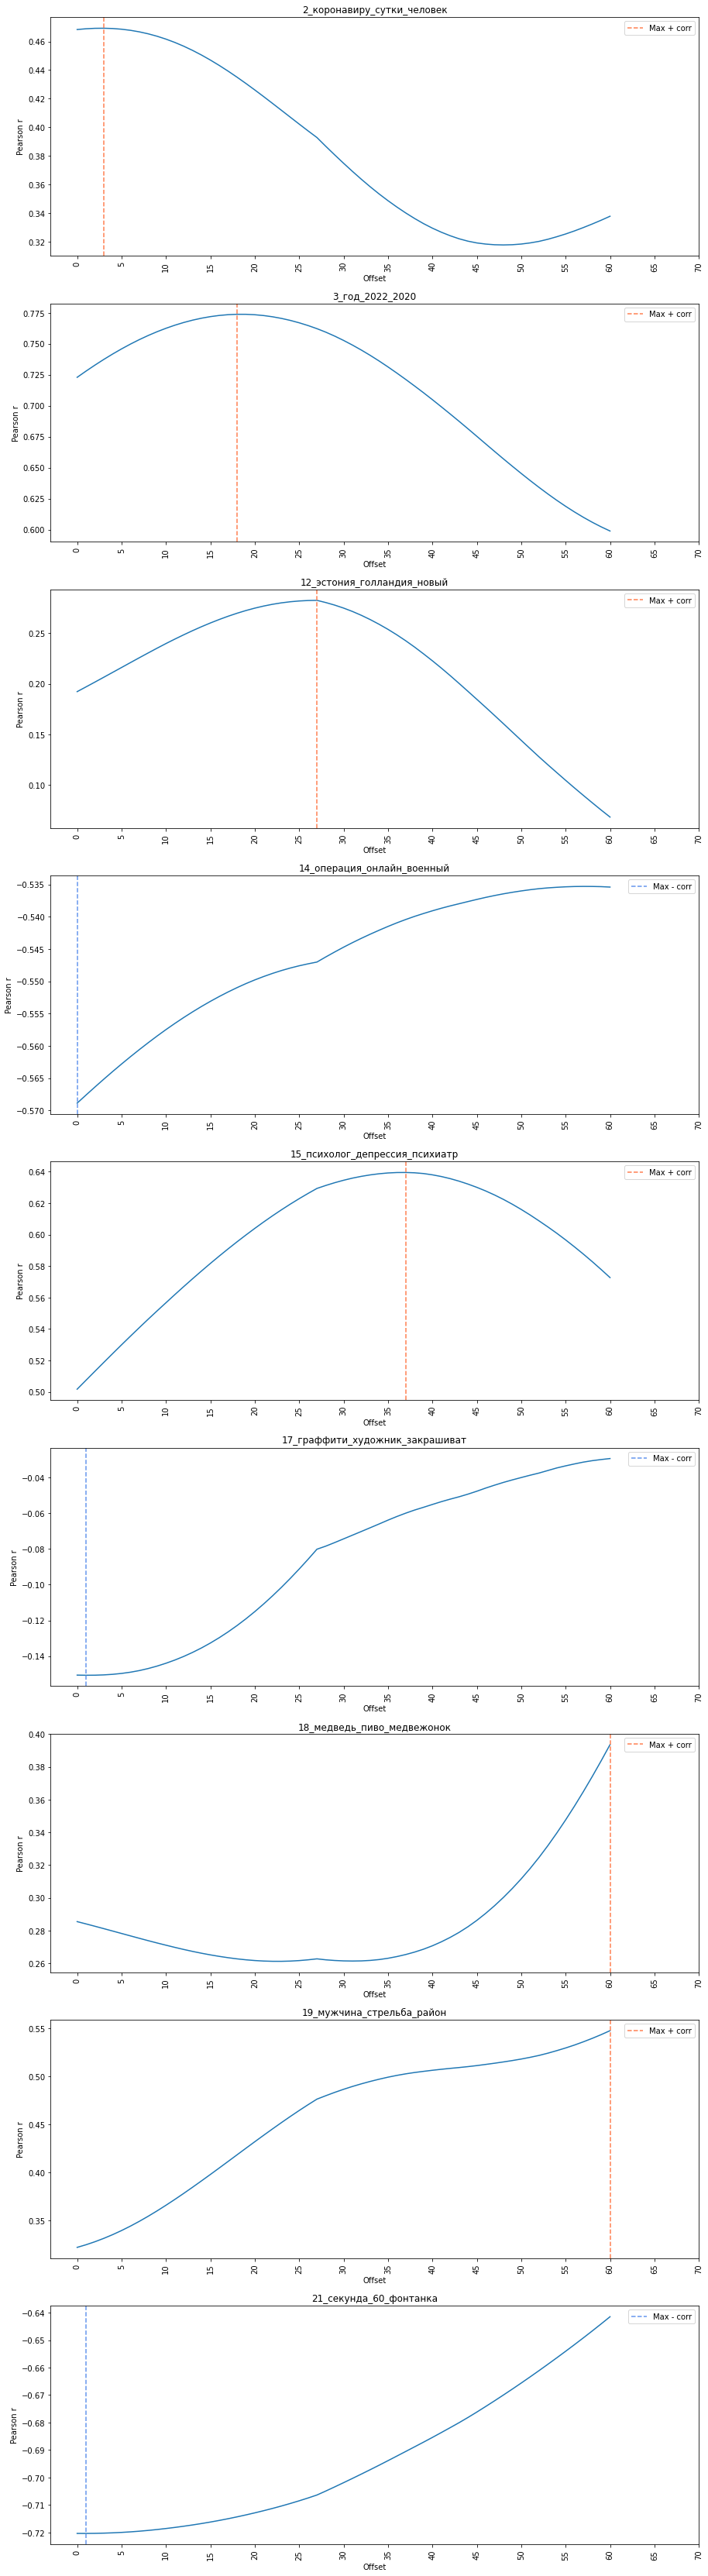

In [37]:
plt.rcParams['figure.figsize'] = [15, 60]
x0, fwd, smwin = 800, 90, 28
max_lag = 60

prds = []

for num, item in enumerate(news.columns):
    plt.subplot(len(news.columns), 1, num+1)
    t1 = data['self_realization'].rolling(smwin).mean().dropna()[:x0]
    t2 = news[item][:x0]
    
    rs = [crosscorr(t1, t2, lag) for lag in range(0, int(max_lag+1))]
    offset = np.floor(len(rs)/2) - np.argmax(rs)

    plt.plot(rs)
    if np.abs(np.max(rs)) >= np.abs(np.min(rs)):
        plt.axvline(np.argmax(rs), color='coral', linestyle='--', label='Max + corr')
        lag = np.argmax(rs)
    else:
        plt.axvline(np.argmin(rs), color='cornflowerblue', linestyle='--', label='Max - corr')
        lag = np.argmin(rs)
    
#     if abs(rs[lag]) >= 0.5:
    prds.append({"prd": item, "lag": lag})
    
    plt.title(item)
    plt.xlabel('Offset')
    plt.ylabel('Pearson r')
    plt.xticks(list(range(0, len(t1), 5)), labels=list(range(0, len(t1), 5)), rotation=90)
    plt.xlim(right=(max_lag + 10))
    plt.legend()
    
plt.rcParams['figure.figsize'] = [15, 7.5]

In [38]:
prds

[{'prd': '2_коронавиру_сутки_человек', 'lag': 3},
 {'prd': '3_год_2022_2020', 'lag': 18},
 {'prd': '12_эстония_голландия_новый', 'lag': 27},
 {'prd': '14_операция_онлайн_военный', 'lag': 0},
 {'prd': '15_психолог_депрессия_психиатр', 'lag': 37},
 {'prd': '17_граффити_художник_закрашиват', 'lag': 1},
 {'prd': '18_медведь_пиво_медвежонок', 'lag': 60},
 {'prd': '19_мужчина_стрельба_район', 'lag': 60},
 {'prd': '21_секунда_60_фонтанка', 'lag': 1}]

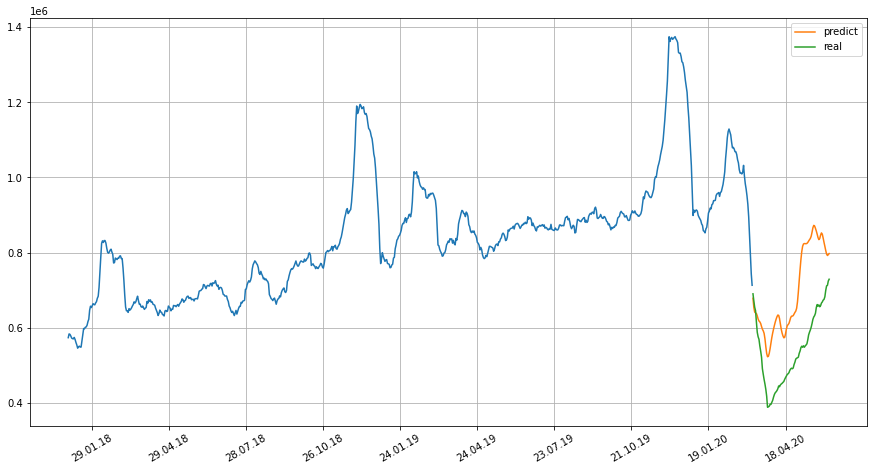

In [39]:
x0, fwd, smwin = 800, 90, 28

dat = data['self_realization'].rolling(smwin).mean().dropna().values

y = MSSAUse(dat[:x0], fwd, prds=prds, predictors=news.iloc[:x0])
x = np.arange(x0, x0+fwd)
xt = np.arange(smwin, x0+fwd+smwin, 90)

plt.plot(dat[:x0])
plt.plot(x, y, label='predict')
plt.plot(x, dat[x0:x0+fwd], label='real')
plt.xticks(xt, data.index.strftime('%d.%m.%y')[xt], rotation=30)
plt.legend()
plt.grid()

# Misc

In [50]:
from io import StringIO

CCM = StringIO("""Topic Lag Score
Annual 1 0.799
Muslim 1 0.797
Theatre 1 0.703
Electric_vehicles 1 0.642
Estonia,_Netherlands 1 0.629
Police 14 0.615
Beer 14 0.586
Cafe 1 0.58
Belorussia 12 0.573
Saint-Petersburg 14 0.527
Parking 11 0.516
Military 1 0.484
QR-code 9 0.48
Russia 14 0.459
Shooting 9 0.454
Masks 1 0.452
Graffitti 1 0.438
COVID-19 1 0.43
Apple 14 0.413
Teacher 14 0.376
Motorcycle 5 0.363
France 1 0.223
Fontanka 1 0.201
Depression 1 0.15""")

granger = StringIO("""Topic Lag Score
COVID-19 1 3.86e-13
Masks 1 2.95e-08
Annual 4 2.98e-06
Parking 1 6.91e-06
Theatre 1 8.37e-05
Russia 1 0.00015253677243095515
Beer 1 0.001
Depression 1 0.001
Graffitti 1 0.001
Muslim 1 0.001
Apple 1 0.004
Cafe 3 0.033
Police 9 0.053
Electric_vehicles 2 0.061
Teacher 1 0.091
France 2 0.095
Military 1 0.096
Belorussia 1 0.098
QR-code 15 0.168
Shooting 9 0.219
Motorcycle 2 0.227
Estonia,_Netherlands 7 0.253
Fontanka 2 0.257
Saint-Petersburg 6 0.498""")

cross_corr = StringIO("""Topic Lag Score
Annual 1 0.79
Police 14 0.75
Saint-Petersburg 14 0.73
Russia 14 0.7
Military 1 0.64
Fontanka 1 0.63
Parking 11 0.62
Teacher 14 0.5
Muslim 1 0.5
Motorcycle 5 0.47
Apple 14 0.47
Masks 1 0.46
COVID-19 1 0.44
Depression 1 0.42
Shooting 9 0.41
QR-code 9 0.38
Theatre 1 0.37
Beer 14 0.34
Graffitti 1 0.3
Cafe 1 0.3
Belorussia 12 0.3
France 1 0.25
Electric_vehicles 1 0.18
Estonia,_Netherlands 1 0.18""")

CCM = pd.read_csv(CCM, sep=" ")
granger = pd.read_csv(granger, sep=" ")
cross_corr = pd.read_csv(cross_corr, sep=" ")

for i in range (5, len(CCM)):
    cur1 = list(CCM["Topic"][:i])
    cur2 = list(granger["Topic"][:i])
    cur3 = list(cross_corr["Topic"][:i])
    
    topics = [x for x in cur1 if (x in cur2) and (x in cur3)]
    print(topics)

['Annual']
['Annual']
['Annual']
['Annual']
['Annual']
['Annual', 'Muslim']
['Annual', 'Muslim', 'Parking']
['Annual', 'Muslim', 'Parking']
['Annual', 'Muslim', 'Police', 'Parking']
['Annual', 'Muslim', 'Police', 'Parking', 'Russia']
['Annual', 'Muslim', 'Police', 'Parking', 'Russia']
['Annual', 'Muslim', 'Police', 'Parking', 'Russia', 'Masks']
['Annual', 'Muslim', 'Theatre', 'Police', 'Parking', 'Military', 'Russia', 'Masks']
['Annual', 'Muslim', 'Theatre', 'Police', 'Beer', 'Parking', 'Military', 'Russia', 'Masks', 'COVID-19']
['Annual', 'Muslim', 'Theatre', 'Police', 'Beer', 'Parking', 'Military', 'QR-code', 'Russia', 'Masks', 'Graffitti', 'COVID-19', 'Apple']
['Annual', 'Muslim', 'Theatre', 'Police', 'Beer', 'Cafe', 'Parking', 'Military', 'QR-code', 'Russia', 'Shooting', 'Masks', 'Graffitti', 'COVID-19', 'Apple', 'Teacher']
['Annual', 'Muslim', 'Theatre', 'Police', 'Beer', 'Cafe', 'Belorussia', 'Parking', 'Military', 'QR-code', 'Russia', 'Shooting', 'Masks', 'Graffitti', 'COVID-19'

In [51]:
tops = ['Annual', 'Muslim', 'Police', 'Parking', 'Russia', 'Masks']

CCM = CCM[CCM["Topic"].isin(tops)].set_index("Topic").sort_index()
granger = granger[granger["Topic"].isin(tops)].set_index("Topic").sort_index()
cross_corr = cross_corr[cross_corr["Topic"].isin(tops)].set_index("Topic").sort_index()

In [55]:
table = CCM.copy()
table = table.rename(columns={"Lag": "Lag_CCM", "Score": "Score_CCM"})
table["Lag_granger"] = granger["Lag"]
table["Score_granger"] = granger["Score"]
table["Lag_cross_corr"] = cross_corr["Lag"]
table["Score_cross_corr"] = cross_corr["Score"]
table

,Lag_CCM,Score_CCM,Lag_granger,Score_granger,Lag_cross_corr,Score_cross_corr
Topic,,,,,,
Annual,1,0.799,4,2.980000e-06,1,0.79
Masks,1,0.452,1,2.950000e-08,1,0.46
Muslim,1,0.797,1,1.000000e-03,1,0.50
Parking,11,0.516,1,6.910000e-06,11,0.62
Police,14,0.615,9,5.300000e-02,14,0.75
Russia,14,0.459,1,1.525368e-04,14,0.70
